In [1]:
!pip install panel hvplot

In [2]:
import pandas
import seaborn
import numpy

import panel as pn
pn.extension('tabulator', sizing_mode="stretch_width")

import random
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from pathlib import Path as path


In [3]:
import hvplot.pandas
import holoviews as hv

hv.extension('bokeh')

In [4]:
from pandas.core.reshape.merge import merge
xtrain = read_csv(path('../data/Xtrain.csv'))
ytrain = read_csv(path('../data/Ytrain.csv'))
xtest = read_csv(path('../data/Xtest.csv'))
ytrain = ytrain.loc[:, ~ytrain.columns.str.contains('^Unnamed')]

In [5]:
def combineTrain(x,y):
  return x.merge(y, left_index= True, right_index= True)

In [6]:
def addDate(x):
  Xtrain_date = x.copy()

  # convert Time to Datetime
  Xtrain_date['date'] = pandas.to_datetime(Xtrain_date['date'], format='%Y/%m/%d')

  # Add new column for weekday
  day = Xtrain_date['date'].dt.day
  weekday = Xtrain_date['date'].dt.weekday
  month = Xtrain_date['date'].dt.month
  Xtrain_date.insert(1,'day',day)
  Xtrain_date.insert(1,'weekday',weekday)
  Xtrain_date.insert(2,'month',month)

  return Xtrain_date

In [7]:
def addTime(x):
  Xtrain_time = x.copy()
  # convert Time to Datetime

  # Add new column for weekday
  hour = pandas.to_datetime(Xtrain_time['hour'], format='%H:%M:%S').dt.hour
  Xtrain_time.insert(1,'intHour',hour)
  return Xtrain_time

In [8]:
def addRoute(x):
  Xtrain_route = x.copy()
  Route = 1
  last = this = Xtrain_route.query("train == 1")["station"].unique()
  x = []
  x.append(1)
  for tra in range(2,56):
    this = Xtrain_route.query("train ==" + str(tra))["station"].unique()
    if last.all() != this.all():
      Route += 1
    x.append(Route)
    last = this

  y = []
  for j in Xtrain_route["train"].unique():
    l = int(j) - 1
    for k in range(0,Xtrain_route.query("train ==" + str(j)).count().max()):
      y.append(x[l])
  Xtrain_route.insert(7,'route',y)
  return Xtrain_route


In [9]:
def addStation(x):
  Xtrain_station = x.copy()

  for i in Xtrain_station["station"].unique():
    Xtrain_station[str(i)] = Xtrain_station["station"] == i
    Xtrain_station[str(i)] = Xtrain_station[str(i)].astype(int)
  return Xtrain_station

In [10]:
def onlyPQ(x):
  Xtrain_pq = x.copy()
  return Xtrain_pq.drop([col for col in Xtrain_pq if col.startswith('p') != True], axis = 1)

In [11]:
def dropCat(t):
  Xtrain_dropCat = t.copy()
  holdt = pandas.DataFrame()
  holdt["type"] = Xtrain_dropCat.dtypes
  #print(holdt)
  holdt["float"] = holdt["type"] == 'float64'
  holdt["int"] =  holdt["type"] == 'int64'
  return Xtrain_dropCat.drop([str(holdt.index[col]) for col in range(0,holdt.shape[0]) if holdt["int"][col] != True and holdt["float"][col] != True], axis=1)

In [12]:
def routeDummy(x):
  X_dummy = x.copy()
  for i in range(X_dummy["route"].min(),X_dummy["route"].max() + 1):
    X_dummy["route" + str(i)] = X_dummy["route"] == i
    X_dummy["route" + str(i)] = X_dummy["route" + str(i)].astype(int)
  X_dummy = X_dummy.drop("route",axis = 1)
  return X_dummy

In [13]:
def environment():
    try:
        get_ipython()
        return "notebook"
    except:
        return "server"

In [14]:
no_of_colors=14
PALETTE=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(no_of_colors)]

In [15]:
xtrain.shape

(31119, 12)

In [16]:
ytrain.shape

(31119, 1)

In [17]:
xtrain.head()

date  train  way station      hour  composition  p1q0  p2q0  p3q0  \
0  2019-01-07      1    0      AD  06:00:00            2   NaN   NaN   NaN   
1  2019-01-08      1    0      AD  06:00:00            2   NaN   NaN   NaN   
2  2019-01-10      1    0      AD  06:00:00            2   NaN   NaN   NaN   
3  2019-01-11      1    0      AD  06:00:00            2   NaN   NaN   NaN   
4  2019-01-14      1    0      AD  06:00:00            2   NaN   NaN   NaN   

    p0q1   p0q2   p0q3  
0  0.201  0.138  0.091  
1  0.204  0.152  0.106  
2  0.213  0.153  0.111  
3  0.213  0.152  0.108  
4  0.210  0.147  0.096

In [18]:
ytrain.head(10)

p0q0
0  0.216
1  0.216
2  0.227
3  0.229
4  0.225
5  0.238
6  0.228
7  0.217
8  0.258
9  0.242

In [19]:
xtrain.isnull().sum()


date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
dtype: int64

In [20]:
ytrain.isnull().sum()

p0q0    0
dtype: int64

In [21]:
dataset0 = combineTrain(xtrain,ytrain)
dataset1 = addDate(dataset0)
dataset2 = addTime(dataset1)
dataset3 = addRoute(dataset2)
dataset4 = addStation(dataset3)
dataset5 = onlyPQ(dataset0)
dataset6 = dropCat(dataset4)
dataset7 = routeDummy(dataset4)
dataset8 = dropCat(dataset7)
idataset = dataset3.interactive()

In [22]:
#Sliders for Integer Groups Classes- only one at a time
Routes = pn.widgets.IntSlider(name='Route', start=1, end=8, step=1)

#Grouped by - classes
timeclasses = dataset3["intHour"].dropna().unique().tolist()

Times = pn.widgets.ToggleGroup(
    name='Times',
    options=["6","7","8","9","11"], 
    value=timeclasses,
    button_type='success')

#Radio Buttons
axisoptions = [col for col in dataset3 if col.startswith('p')]
#Y axis of the plot
yaxis = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=axisoptions,
    button_type='success'
)
stationclasses = dataset3.query("route ==" + str(Routes.value))["station"].unique().tolist()
Stations = pn.widgets.RadioButtonGroup(
    name='Stations',
    options=stationclasses,
    button_type='success')

#X axix of the plot
xaxis = pn.widgets.RadioButtonGroup(
    name='X axis', 
    options=axisoptions,
    button_type='success'
)
groupb = pn.widgets.ToggleGroup(
    name='X axis', 
    options=["station","intHour","weekday","month","day","date"],
    button_type='success'
)

In [23]:
ipipeline = (
    
    idataset[
        (idataset.route == Routes)
    ]

)

In [24]:
imputer = KNNImputer(n_neighbors=3)
dataset9 = imputer.fit_transform(dataset8)

In [25]:
dataset9 = pandas.DataFrame(dataset9)
dataset9.columns = dataset8.columns
dataset9.head()

intHour  weekday  month   day  train  way  composition      p1q0      p2q0  \
0      6.0      0.0    1.0   7.0    1.0  0.0          2.0  0.096667  0.165667   
1      6.0      1.0    1.0   8.0    1.0  0.0          2.0  0.105000  0.182667   
2      6.0      3.0    1.0  10.0    1.0  0.0          2.0  0.123333  0.150333   
3      6.0      4.0    1.0  11.0    1.0  0.0          2.0  0.068000  0.142365   
4      6.0      0.0    1.0  14.0    1.0  0.0          2.0  0.108333  0.142659   

       p3q0   p0q1   p0q2   p0q3   p0q0  
0  0.171333  0.201  0.138  0.091  0.216  
1  0.184667  0.204  0.152  0.106  0.216  
2  0.173889  0.213  0.153  0.111  0.227  
3  0.162222  0.213  0.152  0.108  0.229  
4  0.176222  0.210  0.147  0.096  0.225

In [26]:
dataset0.shape

(31119, 13)

In [27]:
dataset0.head(10)

date  train  way station      hour  composition  p1q0  p2q0  p3q0  \
0  2019-01-07      1    0      AD  06:00:00            2   NaN   NaN   NaN   
1  2019-01-08      1    0      AD  06:00:00            2   NaN   NaN   NaN   
2  2019-01-10      1    0      AD  06:00:00            2   NaN   NaN   NaN   
3  2019-01-11      1    0      AD  06:00:00            2   NaN   NaN   NaN   
4  2019-01-14      1    0      AD  06:00:00            2   NaN   NaN   NaN   
5  2019-01-15      1    0      AD  06:00:00            2   NaN   NaN   NaN   
6  2019-01-17      1    0      AD  06:00:00            2   NaN   NaN   NaN   
7  2019-01-18      1    0      AD  06:00:00            2   NaN   NaN   NaN   
8  2019-01-21      1    0      AD  06:00:00            2   NaN   NaN   NaN   
9  2019-01-22      1    0      AD  06:00:00            2   NaN   NaN   NaN   

    p0q1   p0q2   p0q3   p0q0  
0  0.201  0.138  0.091  0.216  
1  0.204  0.152  0.106  0.216  
2  0.213  0.153  0.111  0.227  
3  0.213  0.152  0.108  0.229  
4  0.210  0.147  0.096  0.225  
5  0.218  0.154  0.106  0.238  
6  0.209  0.140  0.094  0.228  
7  0.207  0.141  0.104  0.217  
8  0.234  0.149  0.111  0.258  
9  0.223  0.151  0.102  0.242

In [28]:
dataset0.isnull().sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
dtype: int64

In [29]:
dataset0.describe()

train      way   composition          p1q0          p2q0  \
count  31119.000000  31119.0  31119.000000  29067.000000  26974.000000   
mean      27.067965      0.0      1.999647      0.234769      0.251392   
std       15.979186      0.0      0.018798      0.166153      0.143506   
min        1.000000      0.0      1.000000      0.000000      0.000000   
25%       13.000000      0.0      2.000000      0.094000      0.136000   
50%       26.000000      0.0      2.000000      0.192000      0.230000   
75%       41.000000      0.0      2.000000      0.363000      0.354000   
max       55.000000      0.0      2.000000      0.934000      0.937000   

               p3q0          p0q1          p0q2          p0q3          p0q0  
count  24935.000000  27917.000000  24720.000000  21527.000000  31119.000000  
mean       0.316867      0.207200      0.222167      0.209845      0.248754  
std        0.150974      0.134709      0.147600      0.144858      0.157367  
min        0.000000      0.004000      0.004000      0.004000      0.000000  
25%        0.196000      0.099000      0.107000      0.100000      0.121000  
50%        0.312000      0.181000      0.188000      0.172000      0.220000  
75%        0.420000      0.294000      0.322000      0.292000      0.360500  
max        0.937000      0.969000      0.974000      0.974000      0.974000

In [30]:
dataset3.head()

date  intHour  weekday  month  day  train  way  route station  \
0 2019-01-07      6.0        0      1    7      1    0      1      AD   
1 2019-01-08      6.0        1      1    8      1    0      1      AD   
2 2019-01-10      6.0        3      1   10      1    0      1      AD   
3 2019-01-11      6.0        4      1   11      1    0      1      AD   
4 2019-01-14      6.0        0      1   14      1    0      1      AD   

       hour  composition  p1q0  p2q0  p3q0   p0q1   p0q2   p0q3   p0q0  
0  06:00:00            2   NaN   NaN   NaN  0.201  0.138  0.091  0.216  
1  06:00:00            2   NaN   NaN   NaN  0.204  0.152  0.106  0.216  
2  06:00:00            2   NaN   NaN   NaN  0.213  0.153  0.111  0.227  
3  06:00:00            2   NaN   NaN   NaN  0.213  0.152  0.108  0.229  
4  06:00:00            2   NaN   NaN   NaN  0.210  0.147  0.096  0.225

In [31]:
dataset4.head()

date  intHour  weekday  month  day  train  way  route station  \
0 2019-01-07      6.0        0      1    7      1    0      1      AD   
1 2019-01-08      6.0        1      1    8      1    0      1      AD   
2 2019-01-10      6.0        3      1   10      1    0      1      AD   
3 2019-01-11      6.0        4      1   11      1    0      1      AD   
4 2019-01-14      6.0        0      1   14      1    0      1      AD   

       hour  ...  AA  AC  AG  AH  AR  AU  BA  BI  BJ  AY  
0  06:00:00  ...   0   0   0   0   0   0   0   0   0   0  
1  06:00:00  ...   0   0   0   0   0   0   0   0   0   0  
2  06:00:00  ...   0   0   0   0   0   0   0   0   0   0  
3  06:00:00  ...   0   0   0   0   0   0   0   0   0   0  
4  06:00:00  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 54 columns]

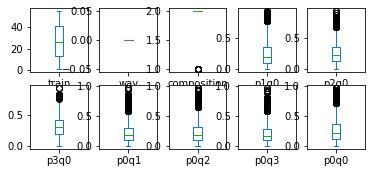

In [32]:
dataset0.plot(kind='box', subplots=True, layout=(3,5), sharex=False, sharey=False)
 
# Plotting a figure of width 3 and height 6
pyplot.rcParams['figure.figsize'] = (18, 9)
pyplot.show()


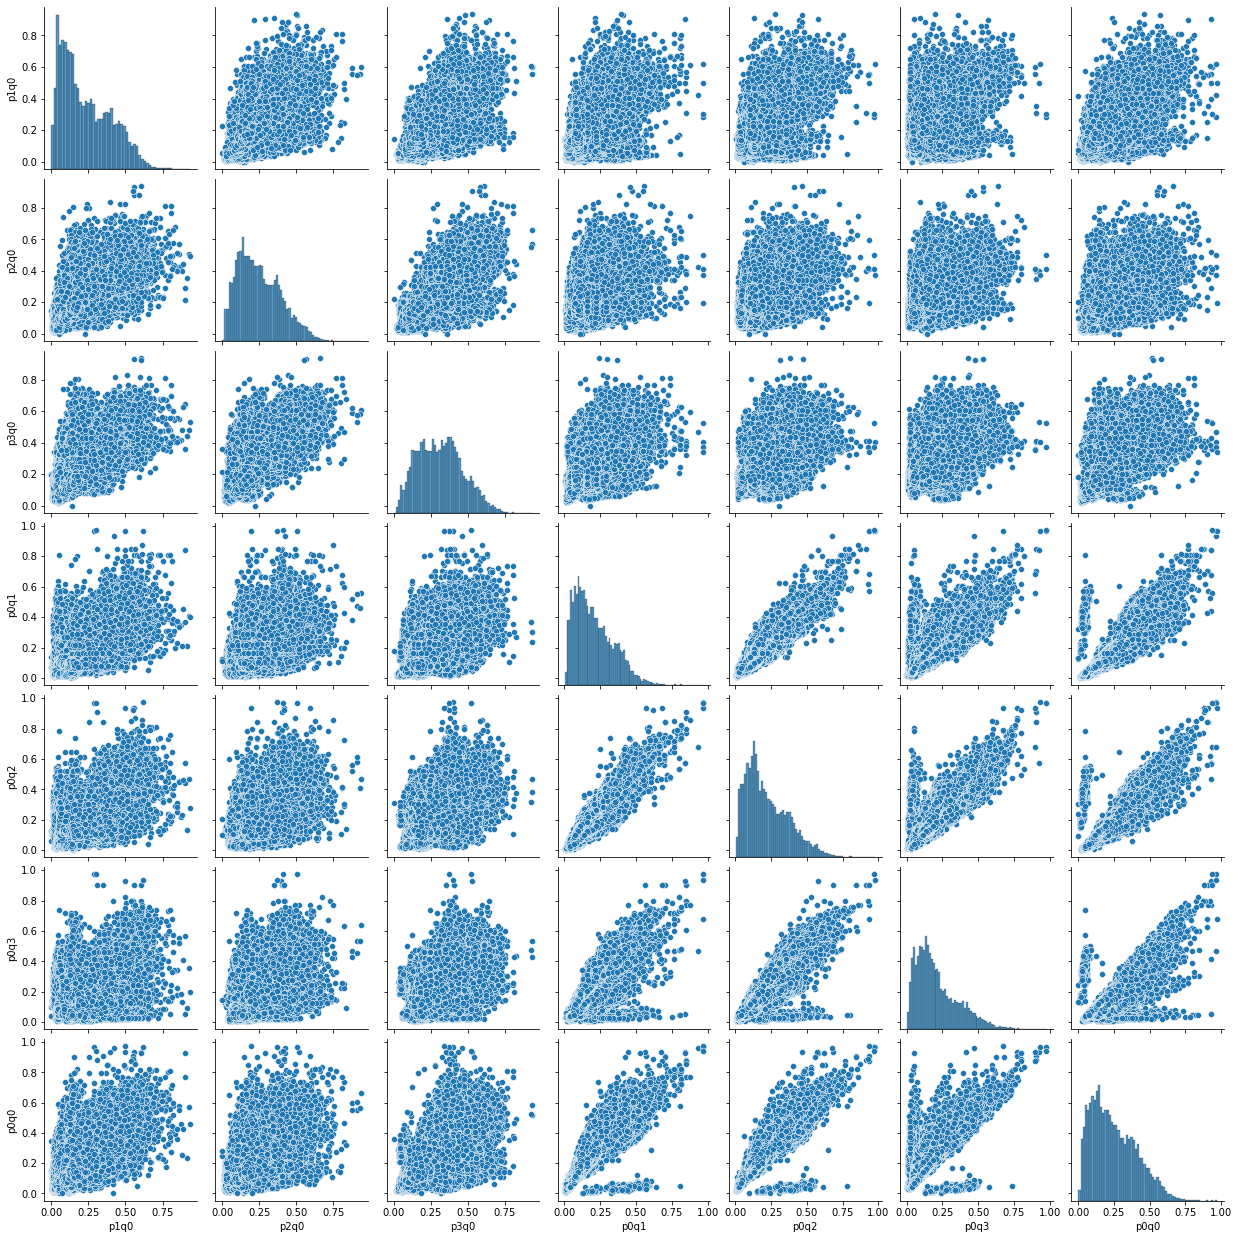

In [33]:
seaborn.pairplot(dataset5)

<AxesSubplot:>

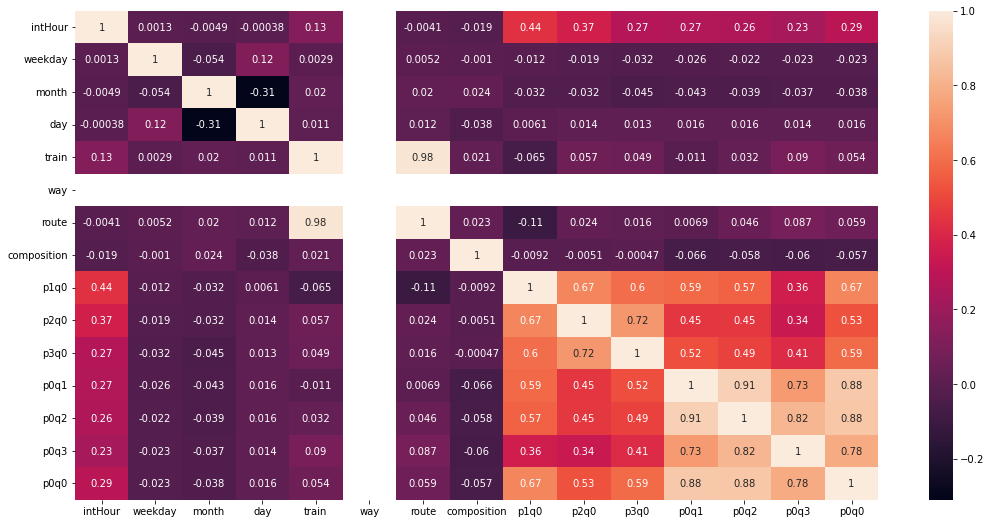

In [34]:
seaborn.heatmap(dataset3.corr(),annot=True)

<AxesSubplot:xlabel='train', ylabel='hour'>

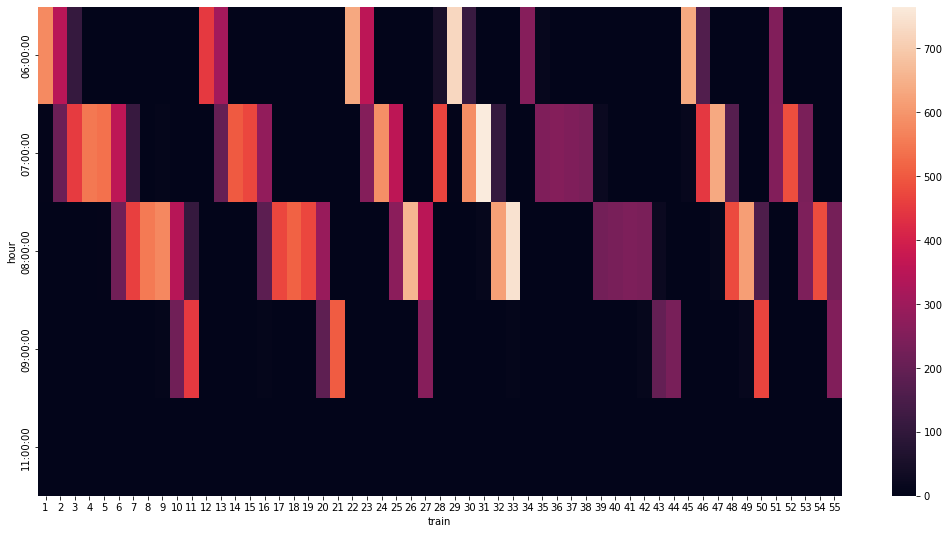

In [35]:
seaborn.heatmap(dataset0.groupby(['hour','train']).size().unstack(fill_value=0))

<AxesSubplot:xlabel='train', ylabel='station'>

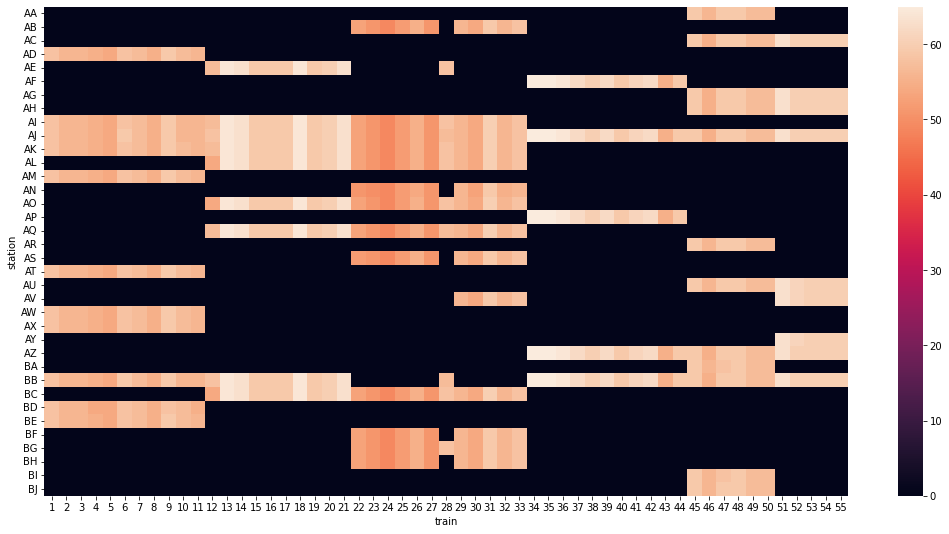

In [36]:
seaborn.heatmap(dataset0.groupby(['station','train']).size().unstack(fill_value=0))

<AxesSubplot:xlabel='intHour', ylabel='station'>

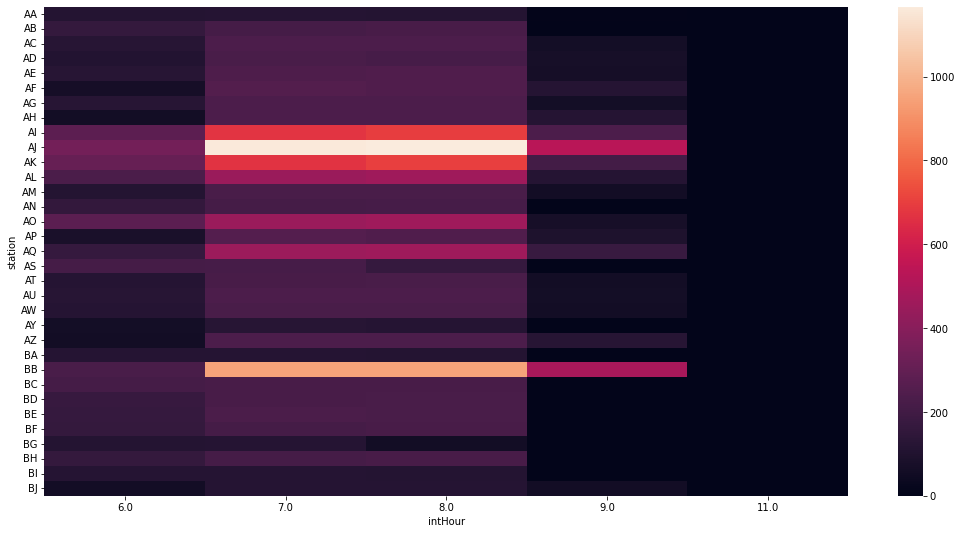

In [37]:
seaborn.heatmap(dataset3.groupby(['station','intHour']).size().unstack(fill_value=0))

<AxesSubplot:xlabel='day', ylabel='train'>

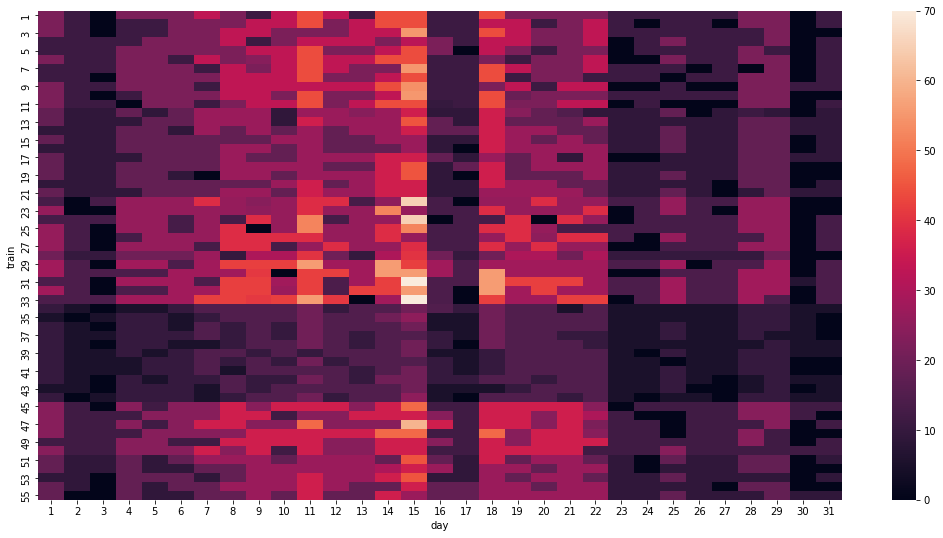

In [38]:
seaborn.heatmap(dataset3.groupby(['train','day']).size().unstack(fill_value=0))

<AxesSubplot:xlabel='route', ylabel='train'>

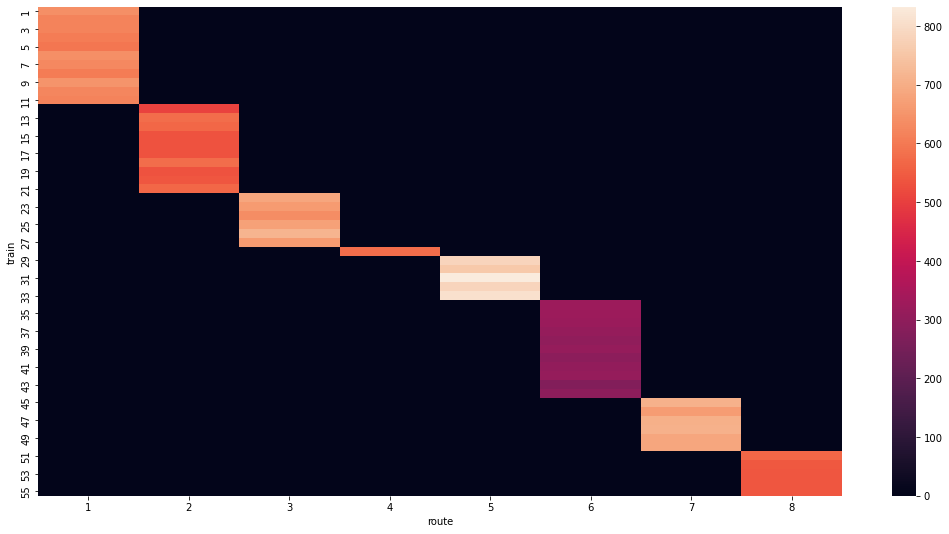

In [39]:
seaborn.heatmap(dataset3.groupby(['train','route']).size().unstack(fill_value=0))

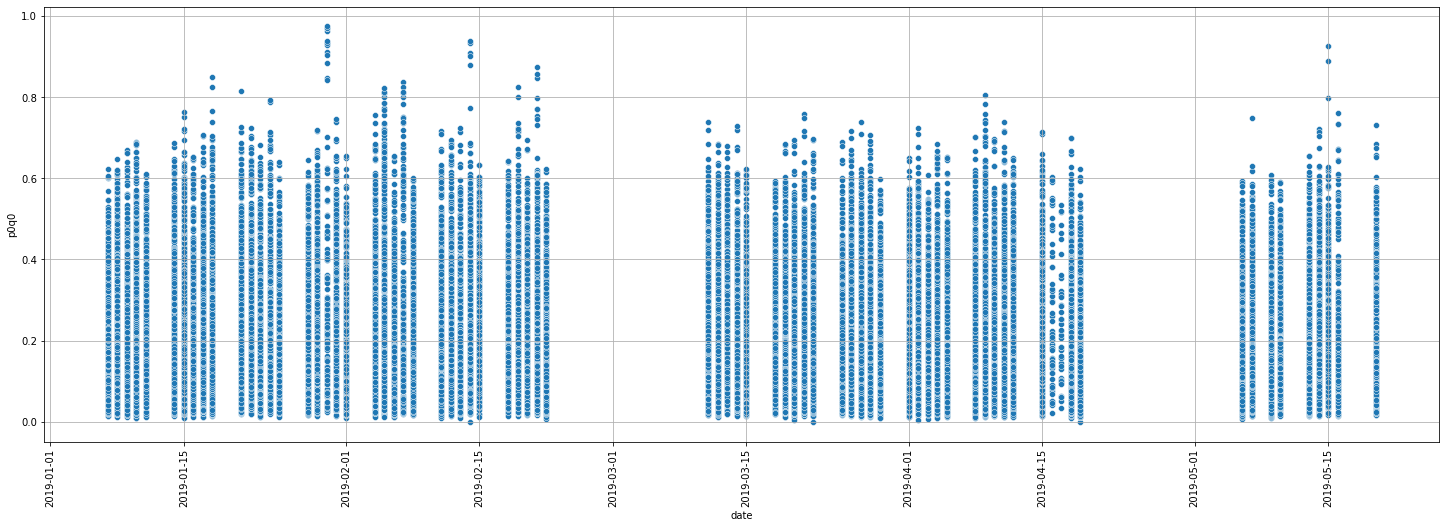

In [40]:
_, ax = plt.subplots(figsize=(25,8))
seaborn.scatterplot(x= dataset3["date"], y= dataset3["p0q0"],ax = ax)
plt.xticks(rotation = 90)
plt.grid()

In [41]:
for i in dataset3.groupby("route")["station"].unique():
  print(i.size)

11
9
13
10
14
5
12
9


In [42]:
itable = ipipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10)
itable

In [43]:
kind = pn.widgets.Select(name='kind', value='scatter', options=['bivariate', 'scatter'])
ihvplot = ipipeline.hvplot(x=xaxis, y=yaxis,by=groupb, color=PALETTE, height=400,kind=kind)
ihvplot

In [44]:
hold = dataset3.groupby(["route","station"]).apply(lambda this: numpy.corrcoef(this["p0q2"],this["p0q0"])[0][1])
car = pandas.DataFrame(hold)
car[0].describe()

count    67.000000
mean      0.937915
std       0.092191
min       0.394543
25%       0.935435
50%       0.964277
75%       0.981509
max       0.997597
Name: 0, dtype: float64

In [45]:
dataset11 = dataset9.copy()
y = dataset11["p0q0"].values
dataset12 = dataset11.drop(["p0q0"],axis = 1)
X = dataset12.values
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [46]:
print(X_train)

[[9.    3.    3.    ... 0.196 0.246 0.235]
 [7.    0.    4.    ... 0.122 0.099 0.083]
 [7.    0.    4.    ... 0.424 0.38  0.034]
 ...
 [7.    0.    1.    ... 0.077 0.064 0.043]
 [6.    4.    1.    ... 0.152 0.108 0.093]
 [8.    4.    3.    ... 0.535 0.525 0.45 ]]


In [47]:
print(Y_train)

[0.269 0.179 0.503 ... 0.105 0.213 0.48 ]


In [48]:
reg = LinearRegression().fit(X_train, Y_train)

In [49]:
reg.score(X_validation,Y_validation)

0.8306794739105591

In [50]:
Y_predict = reg.predict(X_validation)

C:\Users\Ghast\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

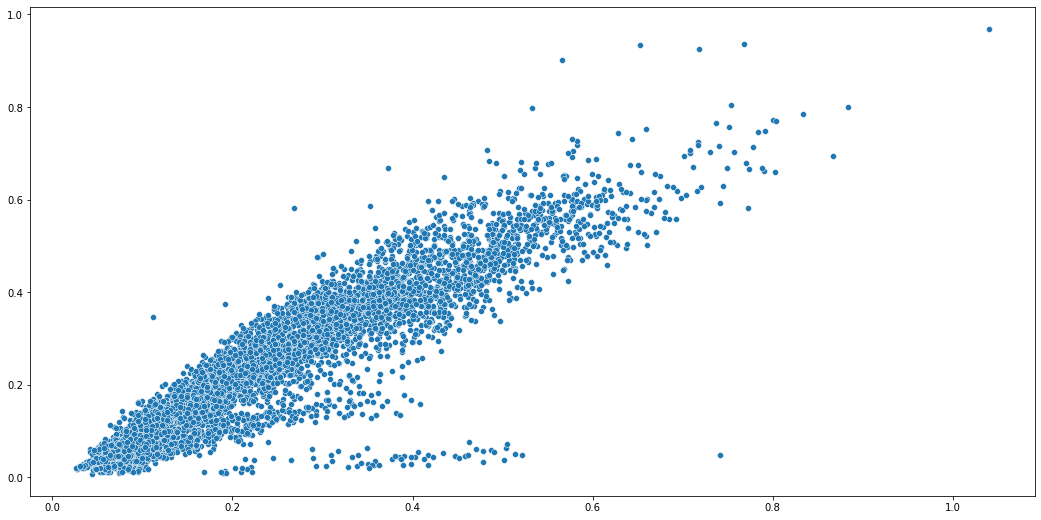

In [51]:
seaborn.scatterplot(Y_predict, Y_validation)

In [52]:
mse = mean_squared_error(Y_validation, Y_predict)
print("Error :" + str(mse))

Error :0.004197290194212804


In [53]:
xtest.count()

date           13752
train          13752
way            13752
station        13752
hour           12346
composition    13752
p1q0           12899
p2q0           12007
p3q0           11092
p0q1           12352
p0q2           10953
p0q3            9556
dtype: int64

In [54]:
newxtest = pandas.DataFrame(routeDummy(dropCat(addStation(addRoute(addTime(addDate(xtest))))))).copy()
newnewxtest = imputer.fit_transform(newxtest)
newnewxtest = pandas.DataFrame(newnewxtest)
newnewxtest.columns = newxtest.columns

Y_predict2 = reg.predict(newnewxtest)

C:\Users\Ghast\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 21 features, but LinearRegression is expecting 13 features as input.

In [ ]:
Ypr = pandas.DataFrame(Y_predict2).copy()
Ypr.rename(columns = {0:'p0q0'}, inplace = True)
Ypr.index = numpy.arange(1, len(Ypr) + 1)
Ypr.to_csv("prediction.csv")